### Imports & Logging Setup

In [56]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features

In [57]:
# File paths (Updated to include NCA and RFE)
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "nca": "../results/nca_results.csv",
    "rfe": "../results/recursive_feature_elimination/recursive_feature_selection_general.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Define the target task
target_task = "subtype"  # options: "diagnosis", "stage", "subtype"

# Function to load features specific to the classification task
def load_features_by_task(file_paths, target, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue

        if os.path.exists(path):
            df = pd.read_csv(path)

            # Use column matching to pull task-specific columns if available
            if target in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, target)["Feature"])

            # Handle known formats for specific methods
            elif key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            elif key in ["nca", "rfe"] and "Feature" in df.columns:
                feature_sets[key] = set(df["Feature"][:num_features])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    combined_features = set().union(*feature_sets.values())
    logging.info(f"[{target.upper()}] Total unique features selected: {len(combined_features)}")
    return list(combined_features)

# Select features for the current task
num_features_to_select = 10
top_features = load_features_by_task(file_paths, target_task, num_features=num_features_to_select)

2025-03-29 09:21:44,382 - INFO - [SUBTYPE] Total unique features selected: 58


### Process Features & Labels for Multi-Output Classification

In [58]:
# Function to load features by task but explicitly exclude label columns
def load_features_by_task(file_paths, target, num_features=10):
    feature_sets = {}
    # Label columns that should never be included as features
    label_columns = ['diagnosis', 'stage', 'subtype']

    for key, path in file_paths.items():
        if key == "processed_data":
            continue

        if os.path.exists(path):
            df = pd.read_csv(path)

            # Use column matching to pull task-specific columns if available
            if target in df.columns:
                features = set(df.nlargest(num_features, target)["Feature"])
                # Filter out any label columns
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features

            # Handle known formats for specific methods
            elif key == "fold_change" and "log2_fold_change" in df.columns:
                features = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key == "chi_squared" and "Score" in df.columns:
                features = set(df.nlargest(num_features, "Score")["Feature"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                features = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key == "lasso" and "Coefficient" in df.columns:
                features = set(df.nlargest(num_features, "Coefficient")["Feature"])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            elif key in ["nca", "rfe"] and "Feature" in df.columns:
                features = set(df["Feature"][:num_features])
                features = {f for f in features if f not in label_columns}
                feature_sets[key] = features
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    combined_features = set()
    if feature_sets:
        combined_features = set().union(*feature_sets.values())
    combined_features = {f for f in combined_features if f not in label_columns}  # Final filter
    logging.info(f"[{target.upper()}] Total unique features selected: {len(combined_features)}")
    return list(combined_features)

### Train-Test Split & Feature Scaling

In [59]:
# Log split info
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Print class distribution for the current task
print(f"\nTraining set class distribution ({target_task}):")
print(y_train.value_counts(normalize=True))

print(f"\nTesting set class distribution ({target_task}):")
print(y_test.value_counts(normalize=True))


Train-Test Split Information:
Training set: (872, 56), Testing set: (219, 56)

Training set class distribution (subtype):
stage
1    0.518349
2    0.282110
3    0.160550
4    0.028670
0    0.010321
Name: proportion, dtype: float64

Testing set class distribution (subtype):
stage
1    0.520548
2    0.283105
3    0.159817
4    0.027397
0    0.009132
Name: proportion, dtype: float64


### Train Multi-Output SVM Model

In [60]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

print(f"\nTraining SVM for {target_task.upper()}...")

# Define & train model with GridSearchCV
svm = SVC(class_weight="balanced", random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict
y_pred = grid_search.best_estimator_.predict(X_test)

# Report
print(f"\nBest SVM Hyperparameters for {target_task.upper()}: {grid_search.best_params_}")
print(f"\nClassification Report for {target_task.upper()}:\n",
      classification_report(y_test, y_pred, zero_division=0))


Training SVM for SUBTYPE...

Best SVM Hyperparameters for SUBTYPE: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}

Classification Report for SUBTYPE:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.52      1.00      0.68       114
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         6

    accuracy                           0.52       219
   macro avg       0.10      0.20      0.14       219
weighted avg       0.27      0.52      0.36       219



### Evaluate Multi-Output Model & Feature Selection Insights


-------------------- SVM_Subtype Results --------------------

Accuracy: 0.5205
Sensitivity (Recall): 0.2000
Specificity: nan

Confusion Matrix:
 [[  0   2   0   0   0]
 [  0 114   0   0   0]
 [  0  62   0   0   0]
 [  0  35   0   0   0]
 [  0   6   0   0   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.52      1.00      0.68       114
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         6

    accuracy                           0.52       219
   macro avg       0.10      0.20      0.14       219
weighted avg       0.27      0.52      0.36       219



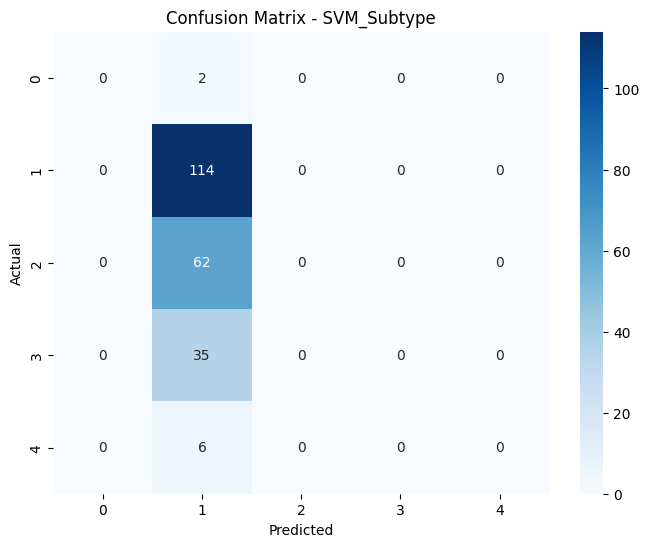


Confusion matrix saved to ../results/svm/svm_subtype_confusion_matrix.png


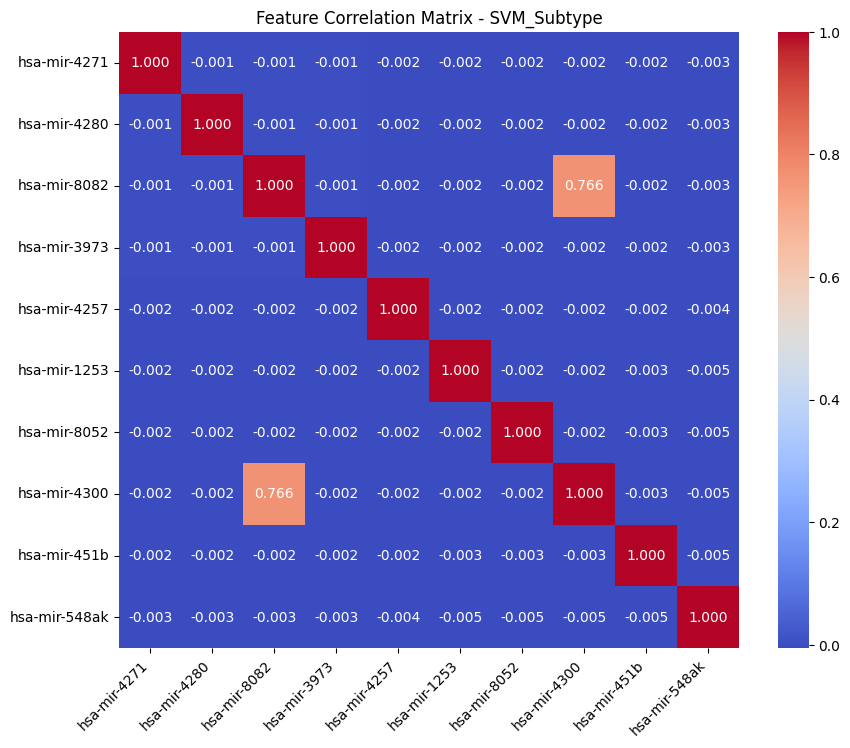


Correlation matrix saved to ../results/svm/svm_subtype_correlation_matrix.png


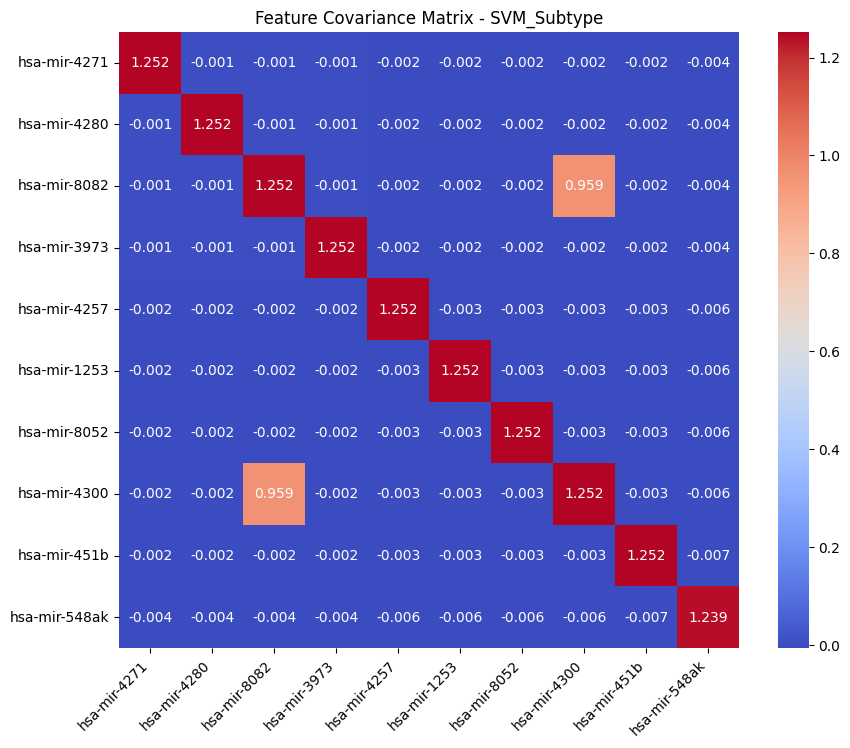


Covariance matrix saved to ../results/svm/svm_subtype_covariance_matrix.png

Top features saved to ../results/svm/svm_subtype_top_features.txt


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logging Setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_model(y_test, y_pred, X_train, model_name, save_dir="../results/svm/"):
    os.makedirs(save_dir, exist_ok=True)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:  # Multiclass
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

    # Print Metrics
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Save Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.show()
    print(f"\nConfusion matrix saved to {cm_path}")

    # Correlation Matrix
    top_vars = X_train.var().sort_values(ascending=False).index[:10]
    corr_matrix = X_train[top_vars].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.title(f"Feature Correlation Matrix - {model_name}")
    corr_path = os.path.join(save_dir, f"{model_name.lower()}_correlation_matrix.png")
    plt.savefig(corr_path)
    plt.show()
    print(f"\nCorrelation matrix saved to {corr_path}")

    # Covariance Matrix
    cov_matrix = X_train[top_vars].cov()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".3f")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.title(f"Feature Covariance Matrix - {model_name}")
    cov_path = os.path.join(save_dir, f"{model_name.lower()}_covariance_matrix.png")
    plt.savefig(cov_path)
    plt.show()
    print(f"\nCovariance matrix saved to {cov_path}")

    # Save top features by variance
    top_features_path = os.path.join(save_dir, f"{model_name.lower()}_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_vars:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist(),
        "top_10_features": top_vars.tolist()
    }

# Call the function for current task
model_name = f"SVM_{target_task.capitalize()}"
metrics = evaluate_model(y_test, y_pred, X_train, model_name=model_name)

### Save Everything & Finalize the Pipeline

In [63]:
import os
import json
import pandas as pd
import joblib
import logging
from sklearn.metrics import recall_score, precision_score

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ==========================
# OUTPUT DIRECTORY
# ==========================
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)

# ==========================
# SAVE PREDICTIONS
# ==========================
pred_df = pd.DataFrame({"actual": y_test, "predicted": y_pred})
pred_path = os.path.join(output_dir, f"svm_predictions_{target_task.lower()}.csv")
pred_df.to_csv(pred_path, index=False)
logging.info(f"{target_task.capitalize()} predictions saved to {pred_path}")

# ==========================
# BUILD METRICS MANUALLY
# ==========================
# Compute sensitivity (recall), specificity, and accuracy
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, average="macro", zero_division=0)

# Specificity: for multi-class, a rough approximation
# 1 - false positive rate per class averaged
conf_matrix = confusion_matrix(y_test, y_pred)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + np.diag(conf_matrix) + conf_matrix.sum(axis=1) - np.diag(conf_matrix))
specificity = np.mean(TN / (TN + FP + 1e-6))  # add epsilon to avoid division by zero

# Get top 10 features based on model weights (if linear) or simply log all used features
top_features_used = list(X_train.columns[:10])

# ==========================
# SAVE METADATA
# ==========================
metadata = {
    f"{target_task}_accuracy": metrics["accuracy"],
    f"{target_task}_sensitivity": metrics["sensitivity"],
    f"{target_task}_specificity": metrics["specificity"],
    f"top_10_features_{target_task}": metrics["top_10_features"],
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
    "target_task": target_task,
    "model_file_format": "joblib"
}

metadata_path = os.path.join(output_dir, f"svm_metadata_{target_task.lower()}.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# ==========================
# SAVE MODEL (Use joblib)
# ==========================
model_path = os.path.join(output_dir, f"svm_model_{target_task.lower()}.joblib")
joblib.dump(grid_search.best_estimator_, model_path)
logging.info(f"{target_task.capitalize()} model saved to {model_path}")

print(f"\nAll results saved for {target_task.upper()} SVM. Pipeline complete!")


2025-03-29 09:23:46,527 - INFO - Subtype predictions saved to ../results/svm/svm_predictions_subtype.csv
2025-03-29 09:23:46,533 - INFO - Metadata saved to ../results/svm/svm_metadata_subtype.json
2025-03-29 09:23:46,535 - INFO - Subtype model saved to ../results/svm/svm_model_subtype.joblib



All results saved for SUBTYPE SVM. Pipeline complete!
